In [1]:
from qaravan.core import *
from qaravan.tensorQ import *

# Usage

In [2]:
# generate a random order of canonizing and check center for each choice of center 

n = 5 
mps = random_mps(n)
center_opts = np.arange(n)
np.random.shuffle(center_opts)

for center in center_opts:
    print(center)
    mps.canonize(center)
    check_center(mps, center, verbose=True)

2
Site 0: L
Site 1: L
Site 2: N
Site 3: R
Site 4: R
1
Site 0: L
Site 1: N
Site 2: R
Site 3: R
Site 4: R
3
Site 0: L
Site 1: L
Site 2: L
Site 3: N
Site 4: R
0
Site 0: R
Site 1: R
Site 2: R
Site 3: R
Site 4: R
4
Site 0: L
Site 1: L
Site 2: L
Site 3: L
Site 4: L


In [3]:
# test environments
n = 5
mps = random_mps(n)

re = mps.compute_right_envs()
le = mps.compute_left_envs()
for i in range(n-1): 
    assert np.allclose(ncon((le[i+1], re[i]), ([1,2],[1,2])), mps.norm())

In [4]:
# test environment with two MPS 
n = 5
mps1 = random_mps(n)
mps2 = random_mps(n)

true_overlap = mps2.to_vector().conj().T @ mps1.to_vector()

re = mps1.compute_right_envs(mps2)
le = mps1.compute_left_envs(mps2)
for i in range(n-1):
    assert np.allclose(ncon((le[i+1], re[i]), ([1,2],[1,2])), true_overlap)

In [5]:
# test overlap method 
n = 6
mps1 = random_mps(n)
mps2 = random_mps(n)
mps_overlap = mps1.overlap(mps2, scaled=False)

sv1 = mps1.to_vector() 
sv2 = mps2.to_vector()
direct_overlap = sv2.conj().T @ sv1 

assert np.allclose(mps_overlap, direct_overlap)

In [12]:
# test fast_measure()

n = 5
mps = random_mps(n)
sv = mps.to_vector()
meas_sites = [1,3]
outcomes = [mps.fast_measure(meas_sites) for _ in tqdm(range(int(1e6)))]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [22]:
true_density_vec = np.diag(rdm_from_sv(sv, meas_sites)).real
num_instances = 5
subsample_sizes = [100, 300, 1000, 3000, 10000, 30000]
mean_errs = []
std_errs = []
for subsample_size in subsample_sizes:
    errs = []
    for _ in range(num_instances):
        subsample_shots = subsample(outcomes, subsample_size)
        subsample_density_vec = shots_to_density_vec(subsample_shots)
        err = np.linalg.norm(true_density_vec - subsample_density_vec, ord=2)
        errs.append(err)
    mean_errs.append(np.mean(errs))
    std_errs.append(np.std(errs)/np.sqrt(num_instances))

thresholds = [l2_threshold(subsample_size, len(meas_sites), delta=1e-12) for subsample_size in subsample_sizes]

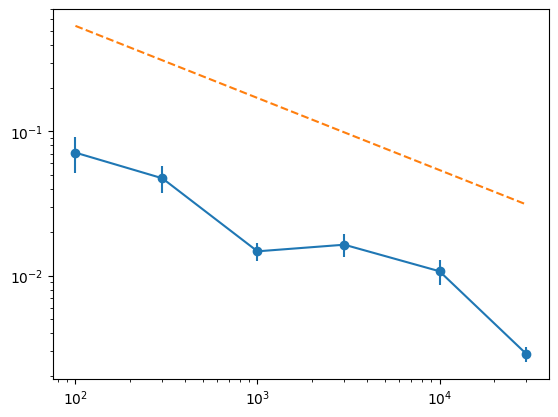

In [23]:
plt.errorbar(subsample_sizes, mean_errs, yerr=std_errs, marker='o')
plt.plot(subsample_sizes, thresholds, '--', label='theoretical threshold')
plt.xscale('log')
plt.yscale('log')

In [24]:
# test one_rdm()
n=5
mps = random_mps(n)

sv = mps.to_vector()
true_rdm = rdm_from_sv(sv, [2])
mps_rdm = mps.one_rdm(2)
assert np.allclose(true_rdm, mps_rdm)

In [25]:
# test one_local_expectation()
n=5
mps = random_mps(n)
sv = mps.to_vector()
op = random_hermitian_op(1)
true_exp = np.trace(op @ rdm_from_sv(sv, [2])).real
mps_exp = mps.one_local_expectation(2, op)
assert np.allclose(true_exp, mps_exp)

# Fast IPR

In [ ]:
import time
from tqdm.notebook import tqdm

num_instances = 5
n = 16 
chi_opts = np.arange(4, 64, 4)
avg_times = []

for chi in tqdm(chi_opts):
    times = []
    for _ in range(num_instances):
        mps = random_mps(n, max_bond_dim = chi)
        sv = mps.to_vector()
        true_ipr = np.sum(np.abs(sv)**4)
        
        start = time.time()
        approx_ipr = fast_ipr(mps)
        end = time.time()

        assert np.allclose(true_ipr, approx_ipr)
        times.append(end - start)
    avg_time = np.mean(times)
    avg_times.append(avg_time)
    print(f"chi={chi}, avg_time={avg_time:.6f} seconds")

In [48]:
chi_opts = chi_opts[0:len(avg_times)]

In [49]:
# do power law interpolation 
log_chi = np.log(chi_opts)
log_times = np.log(avg_times)

# do linear fit using polyfit
coeffs = np.polyfit(log_chi, log_times, 1)
slope = coeffs[0]
intercept = coeffs[1]
print(f"Fitted power law: time = exp({intercept:.4f}) * chi^{slope:.4f}")

Fitted power law: time = exp(-12.7427) * chi^3.6138


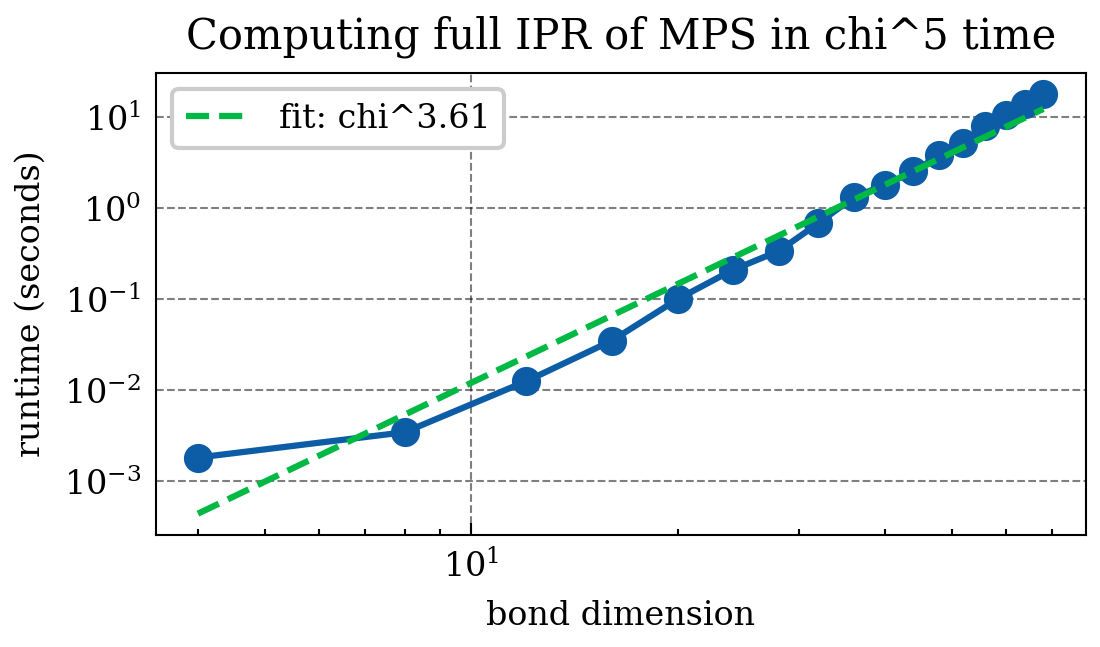

In [50]:
from plotting import * 

set_style()

plt.figure(figsize=(4,2))
plt.plot(chi_opts, avg_times, marker='o')
plt.plot(chi_opts, np.exp(intercept) * chi_opts**slope, linestyle='--', label=f'fit: chi^{slope:.2f}')
plt.xlabel('bond dimension') 
plt.ylabel('runtime (seconds)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Computing full IPR of MPS in chi^5 time')
plt.savefig('mps_fast_ipr.pdf', bbox_inches='tight')